In [10]:
import matplotlib.pyplot as plt
import numpy as np

from ansys.mapdl.core import launch_mapdl
exec_loc = 'C:/Program Files/ANSYS Inc/ANSYS Student/v222/ANSYS/bin/winx64/ANSYS222.exe'
mapdl = launch_mapdl(exec_loc)

In [11]:
###############################################################################
# Element Type and Material Properties
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# This example will use PLANE183 elements as a thin plate can be
# modeled with plane elements provided that KEYOPTION 3 is set to 3
# and a thickness is provided.
#
# This example will use SI units.

mapdl.prep7()
mapdl.units("SI")  # SI - International system (m, kg, s, K).

# define a PLANE183 element type with thickness
mapdl.et(1, "PLANE183", kop3=3)
mapdl.r(1, 0.001)  # thickness of 0.001 meters)

# Define a material (nominal steel in SI)
mapdl.mp("EX", 1, 210e9)  # Elastic moduli in Pa (kg/(m*s**2))
mapdl.mp("DENS", 1, 7800)  # Density in kg/m3
mapdl.mp("NUXY", 1, 0.3)  # Poisson's Ratio

# list currently defined material properties
print(mapdl.mplist())

LIST MATERIALS        1 TO        1 BY        1
  PROPERTY= ALL 

 MATERIAL NUMBER        1

      TEMP        EX  
               0.2100000E+12

      TEMP        NUXY
               0.3000000    

      TEMP        DENS
                7800.000


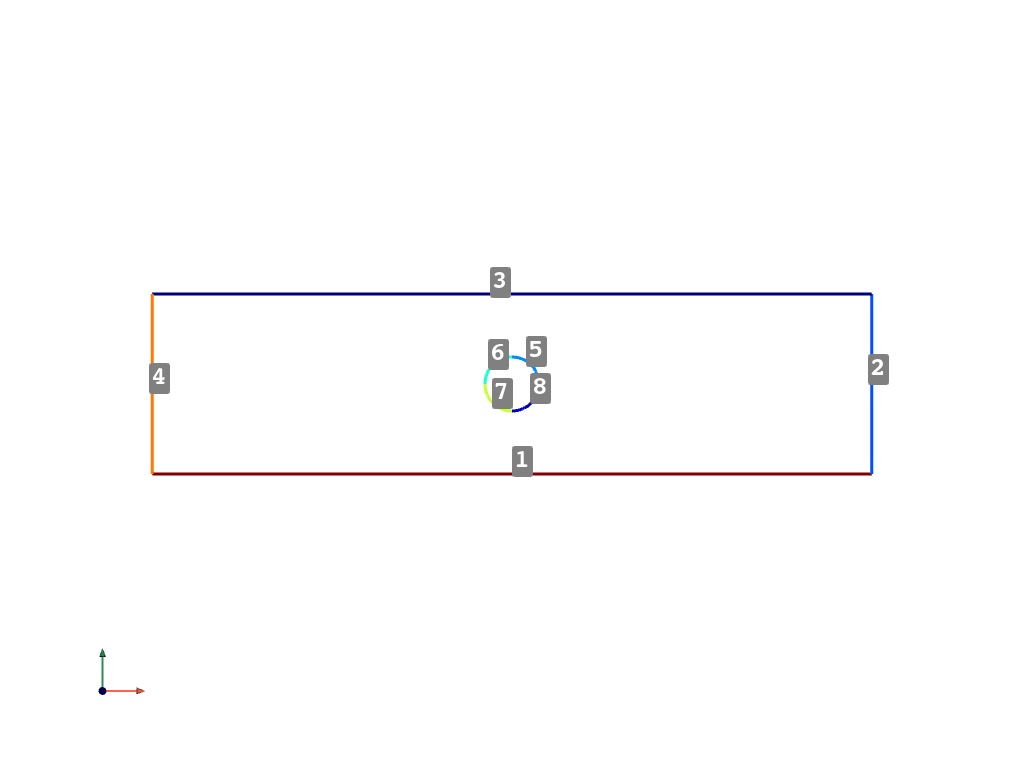

[(0.20000000000000004, 0.05000000000000001, 0.7965228416603691),
 (0.20000000000000004, 0.05000000000000001, 0.0),
 (0.0, 1.0, 0.0)]

In [12]:
###############################################################################
# Geometry
# ~~~~~~~~
# Create a rectangular area with the hole in the middle.  To correctly
# approximate an infinite plate, the maximum stress must occur far
# away from the edges of the plate.  A length to width factor can
# approximate this.

length = 0.4
width = 0.1

ratio = 0.3  # diameter/width
diameter = width * ratio
radius = diameter * 0.5


# create the rectangle
rect_anum = mapdl.blc4(width=length, height=width)

# create a circle in the middle of the rectangle
circ_anum = mapdl.cyl4(length / 2, width / 2, radius)

# Note how pymapdl parses the output and returns the area numbers
# created by each command.  This can be used to execute a boolean
# operation on these areas to cut the circle out of the rectangle.
plate_with_hole_anum = mapdl.asba(rect_anum, circ_anum)

# finally, plot the lines of the plate
mapdl.lplot(cpos="xy", line_width=3, font_size=26, color_lines=True, background="w")

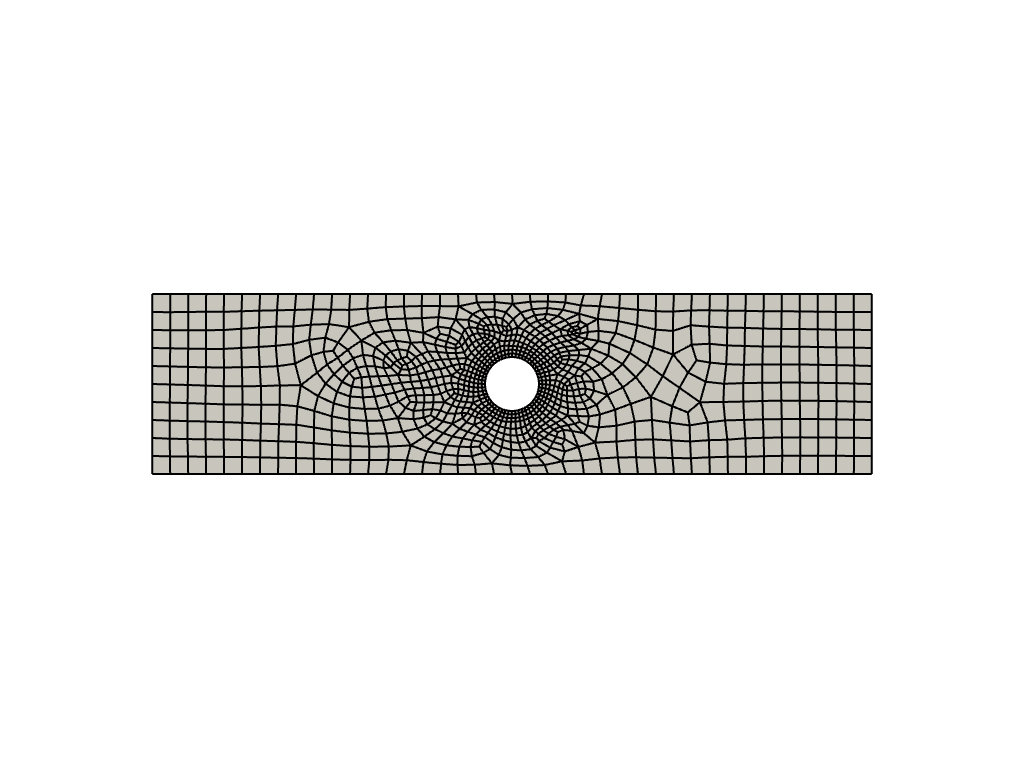

[(0.20000000000000004, 0.05, 0.7965228416603691),
 (0.20000000000000004, 0.05, 0.0),
 (0.0, 1.0, 0.0)]

In [13]:
#%%
###############################################################################
# Meshing
# ~~~~~~~
# Mesh the plate using a higher density near the hole and a lower
# density for the remainder of the plate by setting ``LESIZE`` for the
# lines nearby the hole and ``ESIZE`` for the mesh global size.
#
# Line numbers can be identified through inspection using ``lplot``

# ensure there are at 50 elements around the hole
hole_esize = np.pi * diameter / 50  # 0.0002
plate_esize = 0.01

# increased the density of the mesh at the center
mapdl.lsel("S", "LINE", vmin=5, vmax=8)
mapdl.lesize("ALL", hole_esize, kforc=1)
mapdl.lsel("ALL")

# Decrease the area mesh expansion.  This ensures that the mesh
# remains fine nearby the hole
mapdl.mopt("EXPND", 0.7)  # default 1

mapdl.esize(plate_esize)
mapdl.amesh(plate_with_hole_anum)
mapdl.eplot(
    vtk=True, cpos="xy", show_edges=True, show_axes=False, line_width=2, background="w"
)


In [14]:
# Boundary Conditions
# ~~~~~~~~~~~~~~~~~~~
# Fix the left-hand side of the plate in the X direction and set a
# force of 1 kN in the positive X direction.
#

# Fix the left-hand side.
mapdl.nsel("S", "LOC", "X", 0)
mapdl.d("ALL", "UX")

# Fix a single node on the left-hand side of the plate in the Y
# direction.  Otherwise, the mesh would be allowed to move in the y
# direction and would be an improperly constrained mesh.
mapdl.nsel("R", "LOC", "Y", width / 2)
assert mapdl.mesh.n_node == 1
mapdl.d("ALL", "UY")

# Apply a force on the right-hand side of the plate.  For this
# example, we select the nodes at the right-most side of the plate.
mapdl.nsel("S", "LOC", "X", length)

# Verify that only the nodes at length have been selected:
assert np.allclose(mapdl.mesh.nodes[:, 0], length)

# Next, couple the DOF for these nodes.  This lets us provide a force
# to one node that will be spread throughout all nodes in this coupled
# set.
mapdl.cp(5, "UX", "ALL")

# Select a single node in this set and apply a force to it
# We use "R" to re-select from the current node group
mapdl.nsel("R", "LOC", "Y", width / 2)
mapdl.f("ALL", "FX", 1000)

# finally, be sure to select all nodes again to solve the entire solution
mapdl.allsel(mute=True)


''

In [15]:
# Solve the Static Problem
# ~~~~~~~~~~~~~~~~~~~~~~~~
# Solve the static analysis
mapdl.run("/SOLU")
mapdl.antype("STATIC")
output = mapdl.solve()
print(output)

*** NOTE ***                            CP =       1.406   TIME= 12:57:13
 The automatic domain decomposition logic has selected the MESH domain   
 decomposition method with 2 processes per solution.                     

 *****  MAPDL SOLVE    COMMAND  *****

 *** NOTE ***                            CP =       1.406   TIME= 12:57:13
 There is no title defined for this analysis.                            

 *** SELECTION OF ELEMENT TECHNOLOGIES FOR APPLICABLE ELEMENTS ***
                ---GIVE SUGGESTIONS ONLY---

 ELEMENT TYPE         1 IS PLANE183 WITH PLANE STRESS OPTION. NO SUGGESTION IS
 AVAILABLE.



 *** MAPDL - ENGINEERING ANALYSIS SYSTEM  RELEASE 2022 R2          22.2     ***
 Ansys Mechanical Enterprise Academic Student      
 00000000  VERSION=WINDOWS x64   12:57:13  NOV 09, 2022 CP=      1.406

                                                                               



                       S O L U T I O N   O P T I O N S

   PROBLEM DIMENSIONALITY. . . . . . . 

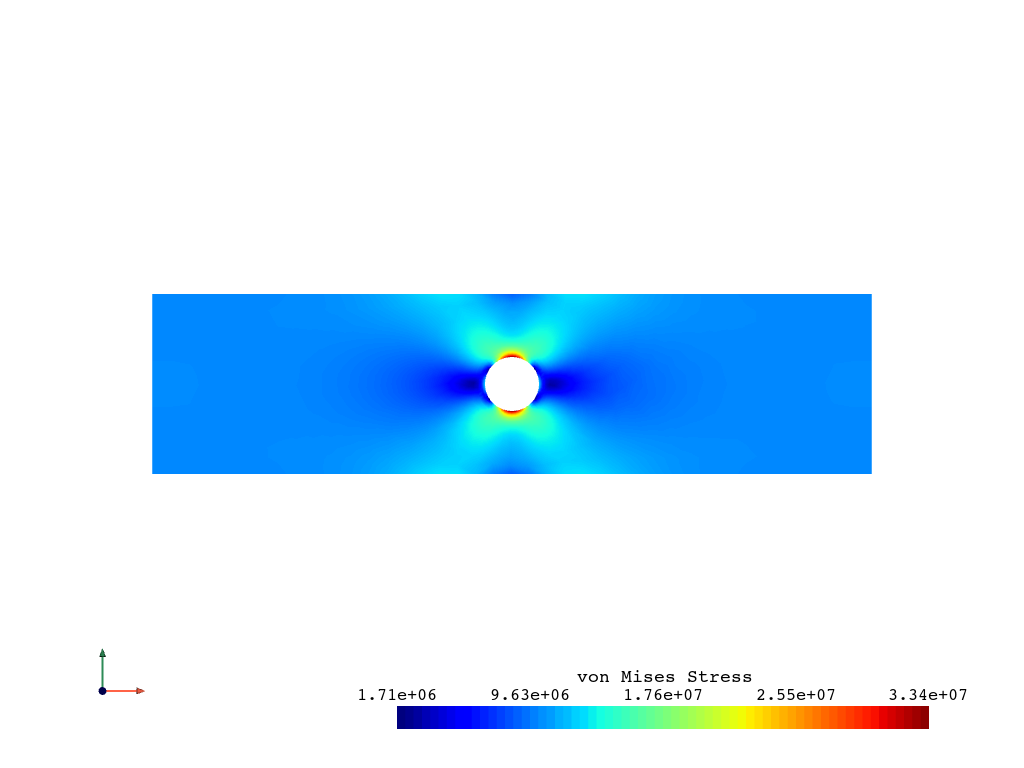

In [16]:
# Post-Processing
# ~~~~~~~~~~~~~~~
# The static result can be post-processed both within MAPDL and
# outside of MAPDL using ``pyansys``.  This example shows how to
# extract the von Mises stress and plot it using the ``pyansys``
# result reader.

# grab the result from the ``mapdl`` instance
result = mapdl.result
result.plot_principal_nodal_stress(
    0, "SEQV", lighting=False, cpos="xy", background="w", text_color="k", add_text=False
)

nnum, stress = result.principal_nodal_stress(0)
von_mises = stress[:, -1]  # von-Mises stress is the right most column

# Must use nanmax as stress is not computed at mid-side nodes
max_stress = np.nanmax(von_mises)

In [17]:
# Compute the Stress Concentration
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# The stress concentration :math:`K_t` is the ratio of the maximum
# stress at the hole to the far-field stress, or the mean cross
# sectional stress at a point far from the hole.  Analytically, this
# can be computed with:
#
# :math:`\sigma_{nom} = \frac{F}{wt}`
#
# Where
#
# - :math:`F` is the force
# - :math:`w` is the width of the plate
# - :math:`t` is the thickness of the plate.
#
# Experimentally, this is computed by taking the mean of the nodes at
# the right-most side of the plate.

# We use nanmean here because mid-side nodes have no stress
mask = result.mesh.nodes[:, 0] == length
far_field_stress = np.nanmean(von_mises[mask])
print("Far field von mises stress: %e" % far_field_stress)
# Which almost exactly equals the analytical value of 10000000.0 Pa

Far field von mises stress: 9.999966e+06


In [18]:
# Since the expected nominal stress across the cross section of the
# hole will increase as the size of the hole increases, regardless of
# the stress concentration, the stress must be adjusted to arrive at
# the correct stress.  This stress is adjusted by the ratio of the
# width over the modified cross section width.
adj = width / (width - diameter)
stress_adj = far_field_stress * adj

# The stress concentration is then simply the maximum stress divided
# by the adjusted far-field stress.
stress_con = max_stress / stress_adj
print("Stress Concentration: %.2f" % stress_con)

Stress Concentration: 2.34


In [21]:
# Batch Analysis
# ~~~~~~~~~~~~~~
# The above script can be placed within a function to compute the
# stress concentration for a variety of hole diameters.  For each
# batch, MAPDL is reset and the geometry is generated from scratch.


def compute_stress_con(ratio):
    """Compute the stress concentration for plate with a hole loaded
    with a uniaxial force.
    """
    mapdl.clear("NOSTART")
    mapdl.prep7()
    mapdl.units("SI")  # SI - International system (m, kg, s, K).

    # define a PLANE183 element type with thickness
    mapdl.et(1, "PLANE183", kop3=3)
    mapdl.r(1, 0.001)  # thickness of 0.001 meters)

    # Define a material (nominal steel in SI)
    mapdl.mp("EX", 1, 210e9)  # Elastic moduli in Pa (kg/(m*s**2))
    mapdl.mp("DENS", 1, 7800)  # Density in kg/m3
    mapdl.mp("NUXY", 1, 0.3)  # Poisson's Ratio
    mapdl.emodif("ALL", "MAT", 1)

    # Geometry
    # ~~~~~~~~
    # Create a rectangular area with the hole in the middle
    diameter = width * ratio
    radius = diameter * 0.5

    # create the rectangle
    rect_anum = mapdl.blc4(width=length, height=width)

    # create a circle in the middle of the rectangle
    circ_anum = mapdl.cyl4(length / 2, width / 2, radius)

    # Note how pyansys parses the output and returns the area numbers
    # created by each command.  This can be used to execute a boolean
    # operation on these areas to cut the circle out of the rectangle.
    plate_with_hole_anum = mapdl.asba(rect_anum, circ_anum)

    # Meshing
    # ~~~~~~~
    # Mesh the plate using a higher density near the hole and a lower
    # density for the remainder of the plate

    mapdl.aclear("all")

    # ensure there are at least 100 elements around the hole
    hole_esize = np.pi * diameter / 100  # 0.0002
    plate_esize = 0.01

    # increased the density of the mesh at the center
    mapdl.lsel("S", "LINE", vmin=5, vmax=8)
    mapdl.lesize("ALL", hole_esize, kforc=1)
    mapdl.lsel("ALL")

    # Decrease the area mesh expansion.  This ensures that the mesh
    # remains fine nearby the hole
    mapdl.mopt("EXPND", 0.7)  # default 1

    mapdl.esize(plate_esize)
    mapdl.amesh(plate_with_hole_anum)
# Boundary Conditions
    # ~~~~~~~~~~~~~~~~~~~
    # Fix the left-hand side of the plate in the X direction
    mapdl.nsel("S", "LOC", "X", 0)
    mapdl.d("ALL", "UX")

    # Fix a single node on the left-hand side of the plate in the Y direction
    mapdl.nsel("R", "LOC", "Y", width / 2)
    assert mapdl.mesh.n_node == 1
    mapdl.d("ALL", "UY")

    # Apply a force on the right-hand side of the plate.  For this
    # example, we select the right-hand side of the plate.
    mapdl.nsel("S", "LOC", "X", length)

    # Next, couple the DOF for these nodes
    mapdl.cp(5, "UX", "ALL")

    # Again, select a single node in this set and apply a force to it
    mapdl.nsel("r", "loc", "y", width / 2)
    mapdl.f("ALL", "FX", 1000)

    # finally, be sure to select all nodes again to solve the entire solution
    mapdl.allsel()

    # Solve the Static Problem
    # ~~~~~~~~~~~~~~~~~~~~~~~~
    mapdl.run("/SOLU")
    mapdl.antype("STATIC")
    mapdl.solve()

    # Post-Processing
    # ~~~~~~~~~~~~~~~
    # grab the stress from the result
    result = mapdl.result
    nnum, stress = result.principal_nodal_stress(0)
    von_mises = stress[:, -1]
    max_stress = np.nanmax(von_mises)

    # compare to the "far field" stress by getting the mean value of the
    # stress at the wall
    mask = result.mesh.nodes[:, 0] == length
    far_field_stress = np.nanmean(von_mises[mask])

    # adjust by the cross sectional area at the hole
    adj = width / (width - diameter)
    stress_adj = far_field_stress * adj

    # finally, compute the stress concentration
    return max_stress / stress_adj

In [22]:
 


###############################################################################
# Run the batch and record the stress concentration
k_t_exp = []
ratios = np.linspace(0.01, 0.5, 10)
print("    Ratio  : Stress Concentration (K_t)")
for ratio in ratios:
    stress_con = compute_stress_con(ratio)
    print("%10.4f : %10.4f" % (ratio, stress_con))
    k_t_exp.append(stress_con)

    Ratio  : Stress Concentration (K_t)
    0.0100 :     3.3066
    0.0644 :     2.8023
    0.1189 :     2.6482
    0.1733 :     2.5151
    0.2278 :     2.3921
    0.2822 :     2.2883
    0.3367 :     2.1963
    0.3911 :     2.1165
    0.4456 :     2.0469
    0.5000 :     1.9850


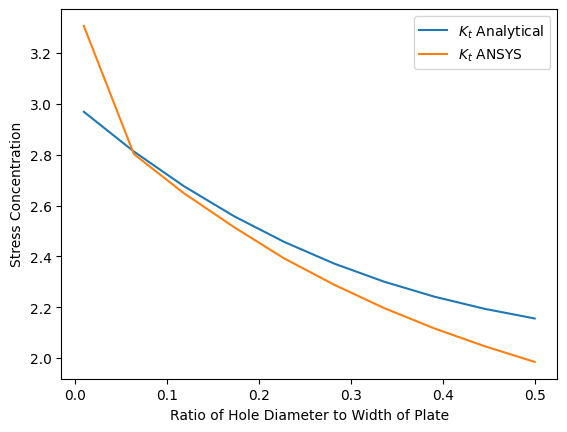

In [23]:
# Analytical Comparison
# ~~~~~~~~~~~~~~~~~~~~~
# Stress concentrations are often obtained by referencing tablular
# results or polynominal fits for a variety of geometries.  According
# to Peterson's Stress Concentration Factors (ISBN 0470048247), the analytical
# equation for a hole in a thin plate in uniaxial tension:
#
# :math:`k_t = 3 - 3.14\frac{d}{h} + 3.667\left(\frac{d}{h}\right)^2 - 1.527\left(\frac{d}{h}\right)^3`
#
# Where:
#
# - :math:`k_t` is the stress concentration
# - :math:`d` is the diameter of the circle
# - :math:`h` is the height of the plate
#
# As shown in the following plot, ANSYS matches the known tabular
# result for this geometry remarkably well using PLANE183 elements.
# The fit to the results may vary depending on the ratio between the
# height and width of the plate.

# where ratio is (d/h)
k_t_anl = 3 - 3.14 * ratios + 3.667 * ratios**2 - 1.527 * ratios**3

plt.plot(ratios, k_t_anl, label=r"$K_t$ Analytical")
plt.plot(ratios, k_t_exp, label=r"$K_t$ ANSYS")
plt.legend()
plt.xlabel("Ratio of Hole Diameter to Width of Plate")
plt.ylabel("Stress Concentration")
plt.show()

In [24]:
mapdl.exit()